In [2]:
from bitalg.visualizer.main import Visualizer
from typing import Tuple, List
from data import raw
from data.raw import EPSILON, P0
from numpy import sign
from functools import cmp_to_key

## Load Data

In [3]:
class Node:
    def __init__(self, x: float, y: float):
        # coordinates
        self.x = x
        self.y = y

        # neighbours
        self.nodesOut = []  # (Node,weight)
        self.nodesIn = []  # (Node,weight)

        # for weight processing
        self.wIn = 0
        self.wOut = 0

    def __str__(self):
        return f"{self.x,self.y}"

    def __repr__(self):
        return f"{self.x,self.y}"


def loadData(
    vertices: List[Tuple[float, float]], edges: List[Tuple[int, int]]
) -> List[Node]:  # zakladam, ze wierzcholki sa juz posortowane rosnaco
    """Loads data from raw.py file"""
    Nodes = [Node(x, y) for (x, y) in vertices]

    for i, j in edges:
        # validate input, so that i<j
        i, j = sorted([i, j])

        # initialize weights with 1's
        Nodes[i].nodesOut.append((Nodes[j], 1))
        Nodes[j].nodesIn.append((Nodes[i], 1))

    return Nodes

In [4]:
def sortEdges(vertices: List[Node]):
    """Sorts edges from rightmost to leftmost"""
    global P0
    for vertex in vertices:
        P0 = (vertex.x, vertex.y)
        vertex.nodesOut.sort(key=cmp_to_key(cmp1))
        vertex.nodesIn.sort(key=cmp_to_key(cmp2))


def det(a, b, c):
    result = (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])
    return result


def cmp1(n1: Tuple[Node, int], n2: Tuple[Node, int]):
    b = (n1[0].x, n1[0].y)
    c = (n2[0].x, n2[0].y)
    d = det(P0, b, c)
    if abs(d) < EPSILON:
        raise ValueError("Two edges with the same angle")
    else:
        return sign(-d)


def cmp2(n1: Tuple[Node, int], n2: Tuple[Node, int]):
    b = (n1[0].x, n1[0].y)
    c = (n2[0].x, n2[0].y)
    d = det(P0, b, c)
    if abs(d) < EPSILON:
        raise ValueError("Two edges with the same angle")
    else:
        return sign(d)

## Calculate weights

In [5]:
def calculateWeights(vertices: List[Node]):
    sortEdges(vertices)

    for vertex in vertices[1:-1]:  # without first and last vertex
        vertex.wIn = sum([w for (_, w) in vertex.nodesIn])
        vertex.wOut = len([w for (_, w) in vertex.nodesOut])

        if vertex.wIn > vertex.wOut:
            # v - leftmost Node
            (v, w) = vertex.nodesOut.pop()
            vertex.nodesOut.append((v, w + vertex.wIn - vertex.wOut))
            # change in v's nodesIn
            idx = v.nodesIn.index((vertex, w))
            v.nodesIn[idx] = (vertex, w + vertex.wIn - vertex.wOut)

    for vertex in reversed(vertices[1:-1]):  # without first and last vertex
        vertex.wIn = sum([w for (_, w) in vertex.nodesIn])
        vertex.wOut = sum([w for (_, w) in vertex.nodesOut])

        if vertex.wOut > vertex.wIn:
            # v - leftmost Node
            (v, w) = vertex.nodesIn.pop()
            vertex.nodesIn.append((v, w + vertex.wOut - vertex.wIn))
            # change in v's nodesOut
            idx = v.nodesOut.index((vertex, w))
            v.nodesOut[idx] = (vertex, w + vertex.wOut - vertex.wIn)

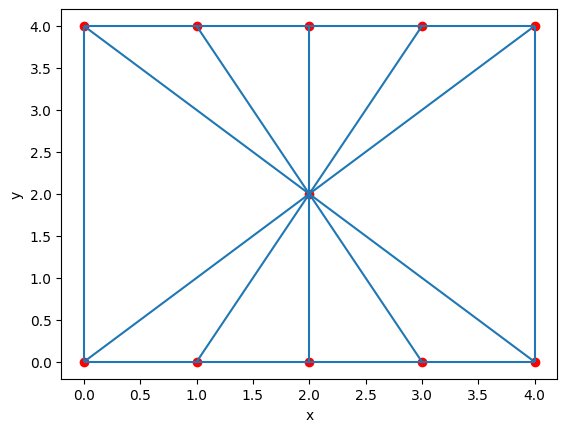

In [6]:
vertices = loadData(raw.test1_vertices, raw.test1_edges)
# visualize graph
vis = Visualizer()
points = [(n.x, n.y) for n in vertices]
segments = []
for n in vertices:
    for out in n.nodesOut:
        segments.append(((n.x, n.y), (out[0].x, out[0].y)))
vis.add_point(points, color="red")
vis.add_line_segment(segments)
vis.show()

In [7]:
calculateWeights(vertices)
for vertex in vertices:
    print(f"VERTEX {vertex.x,vertex.y}")
    print("IN: ", end="")
    for n, w in vertex.nodesIn:
        print(f"{n} {w}", end=" | ")
    print()
    print("OUT: ", end="")
    for n, w in vertex.nodesOut:
        print(f"{n} {w}", end=" | ")
    print()

VERTEX (0, 0)
IN: 
OUT: (1, 0) 5 | (2, 2) 1 | (0, 4) 1 | 
VERTEX (1, 0)
IN: (0, 0) 5 | 
OUT: (2, 0) 4 | (2, 2) 1 | 
VERTEX (2, 0)
IN: (1, 0) 4 | 
OUT: (3, 0) 3 | (2, 2) 1 | 
VERTEX (3, 0)
IN: (2, 0) 3 | 
OUT: (4, 0) 2 | (2, 2) 1 | 
VERTEX (4, 0)
IN: (3, 0) 2 | 
OUT: (4, 4) 1 | (2, 2) 1 | 
VERTEX (2, 2)
IN: (4, 0) 1 | (3, 0) 1 | (2, 0) 1 | (1, 0) 1 | (0, 0) 1 | 
OUT: (4, 4) 1 | (3, 4) 1 | (2, 4) 1 | (1, 4) 1 | (0, 4) 1 | 
VERTEX (0, 4)
IN: (2, 2) 1 | (0, 0) 1 | 
OUT: (1, 4) 2 | 
VERTEX (1, 4)
IN: (2, 2) 1 | (0, 4) 2 | 
OUT: (2, 4) 3 | 
VERTEX (2, 4)
IN: (2, 2) 1 | (1, 4) 3 | 
OUT: (3, 4) 4 | 
VERTEX (3, 4)
IN: (2, 2) 1 | (2, 4) 4 | 
OUT: (4, 4) 5 | 
VERTEX (4, 4)
IN: (4, 0) 1 | (2, 2) 1 | (3, 4) 5 | 
OUT: 


## Build separators

In [8]:
class Separator:
    def __init__(self):
        self.points = []
        self.edges = []

    def addPoint(self, point: Tuple[float, float]):
        self.points.append(point)

    def addEdge(self, edge: Tuple[Tuple[float, float], Tuple[float, float]]):
        self.edges.append(edge)

In [9]:
def findSeparators(graph):
    def buildSeparator(source: Node, separator: Separator):
        point = source
        while len(point.nodesOut)!=0:
            separator.addPoint((point.x,point.y))
            out = point.nodesOut
            # find lefmost non-zero weight edge
            i = len(out) - 1
            while out[i][1] == 0:
                i -= 1
            out[i] = (out[i][0], out[i][1] - 1)
            point=out[i][0]
        # add sink
        separator.addPoint((point.x,point.y))

    # number of separators
    n = sum([w for (_, w) in graph[0].nodesOut])
    separators = [Separator() for _ in range(n)]
    for i in range(n):
        buildSeparator(graph[0], separators[i])

    # build edges
    for i in range(n):
        points = separators[i].points
        for o in range(len(points) - 1):
            separators[i].addEdge((points[o], points[o + 1]))
    return separators

In [10]:
separators = findSeparators(vertices)

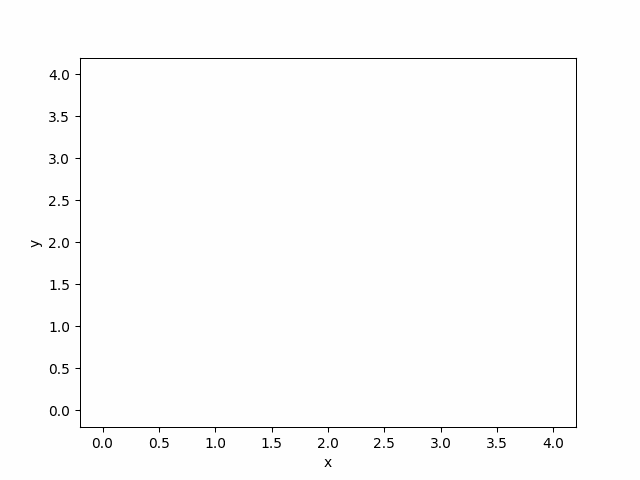

In [11]:
for separator in separators:
    to_remove = vis.add_line_segment(separator.edges, color="black")
    vis.remove_figure(to_remove)
vis.show_gif(interval=500)

## Build a BST

In [12]:
class TreeNode:
    def __init__(self, segments: List[Tuple[Tuple[float, float], Tuple[float, float]]],separator:Separator,parent):
        self.right  = None
        self.left = None
        self.parent=parent
        self.segments = segments
        self.separator=separator

In [13]:
def arrayToBST(array: List, parent:TreeNode) -> TreeNode:
    # nonlocal visited

    if not array:
        return None
    # build root
    mid = len(array) // 2
    newEdges = []
    for edge in array[mid].edges:
        # odcinki w edges zawsze sa posortowane ? (a,b) -> a<=b (chyba tak), jezeli nie trzeba sprawdzic dla edge=(a,b): (b,a) not in visited
        # if edge not in visited:
        newEdges.append(edge)
        # visited.add(edge)
    # print(newEdges)
    root = TreeNode(newEdges,array[mid],parent)
    root.left = arrayToBST(array[:mid],root)

    root.right = arrayToBST(array[mid + 1 :],root)

    return root

In [14]:
def printTree(node, level=0):
    if node != None:
        printTree(node.left, level + 1)
        print(' ' * 4 * level + '-> ' + str(len(node.segments)))
        printTree(node.right, level + 1)

In [15]:
def location(point :Tuple[float,float], root :TreeNode,prev :TreeNode):
    # print(root.segments)
    if root == None:
        # print("xd2")
        return prev.separator
    x, y=point
    # print(root.segments)
    # print(root.segments)
    # print(point)
    for p1, p2 in root.segments:
        if p1[1]<=y<=p2[1]:
            d=det(p1,p2,point)
            if d<0: # prawa strona
                # print("right")
                # print(root.right.segments)
                return location(point,root.right,root)
            elif d>0:
                # print("left")
                return location(point,root.left,root)
            else:
                print("xd")
                # sprawdzenie czy punkt faktycznie nalezy do odcinka
                if p1[0] > p2[0]: p1,p2=p2,p1
                if p1[0]<=x<=p2[0]:
                    return (p1,p2)
    print("?")

In [16]:
def second_separator(s :Separator,separators,point):
    idx=separators.index(s)
    _, y=point
    for p1,p2 in s.edges:
        if p1[1]<=y<=p2[1]:
            d=det(p1,p2,point)
            if d<0: # prawa strona
                return separators[idx+1]
            elif d>0:
                return separators[idx-1]

In [17]:
def exact_area_edges(sep1,sep2,point):
    n1,n2=len(sep1),len(sep2)
    i=0
    j=0
    edges=[]
    while i<n1 and j<n2:
        if sep1[i]==sep2[j]:
            i+=1
            j+=1
        else:
            while  i<n1 and j<n2:
                if sep1[i][1]==sep2[j][1]:
                    edges.append(sep1[i])
                    edges.append(sep2[j])
                    i+=1
                    j+=1
                    if edges[-1][1][1]>point[1]:
                        return edges
                    else:
                      edges=[]
                      break
                if sep1[i][1][1]<sep2[j][1][1]:
                    edges.append(sep1[i])
                    i+=1
                elif sep1[i][1][1]>sep2[j][1][1]:
                    edges.append(sep2[j])
                    j+=1
                else:
                    if j<n2-1 and sep1[i][1]==sep2[j+1][1]:
                        edges.append(sep2[j])
                        j+=1
                    elif i < n1-1 and sep2[j][1]==sep1[i+1][1]:
                        edges.append(sep1[i])
                        i+=1
                    else:
                        edges.append(sep1[i])
                        edges.append(sep2[j])
                        i+=1
                        j+=1

In [18]:
def separators_method_point_location_algorithm(raw_vertices,raw_edges,point):
    
    v=loadData(raw_vertices,raw_edges)
    calculateWeights(v)
    separators=findSeparators(v)
    
    r = arrayToBST(separators,None)
    # printTree(r)
    sepl=location(point,r,None)
    # print(sepl.edges)
    if isinstance(sepl,Separator):
        sepr=second_separator(sepl,separators,point)
        print(sepr.edges)
    else:
        print("W punkt")
        return sepl
    
    return exact_area_edges(sepl.edges,sepr.edges,point)

In [19]:
def separators_method_point_location_algorithm_visualiser(raw_vertices,raw_edges,point):
    vertices = loadData(raw_vertices, raw_edges)

    # visualize graph
    vis = Visualizer()
    points = [(n.x, n.y) for n in vertices]
    segments = []
    for n in vertices:
        for out in n.nodesOut:
            segments.append(((n.x, n.y), (out[0].x, out[0].y)))
    edges=separators_method_point_location_algorithm(raw_vertices, raw_edges,point)
    vis.add_point(points, color="red")
    vis.add_point(point, color="green")
    vis.add_line_segment(segments)
    print(edges)
    vis.add_line_segment(edges,color='red')
    return vis,edges

xd
xd
xd
xd
xd
W punkt
((2, 0), (3, 0))


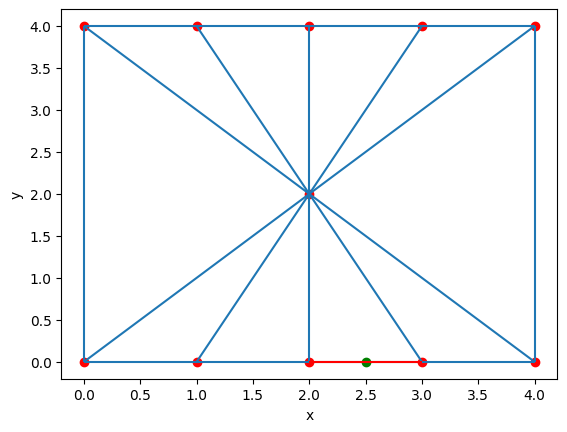

In [20]:
point1=(2.5,0)
vis1,e=separators_method_point_location_algorithm_visualiser(raw.test1_vertices, raw.test1_edges,point1)
vis1.show()

[((2, 0), (2, 1)), ((2, 1), (3, 1)), ((3, 1), (3, 2)), ((3, 2), (4, 2)), ((4, 2), (2, 4))]
[((3, 1), (3, 2)), ((3, 1), (4, 2)), ((3, 2), (4, 2))]


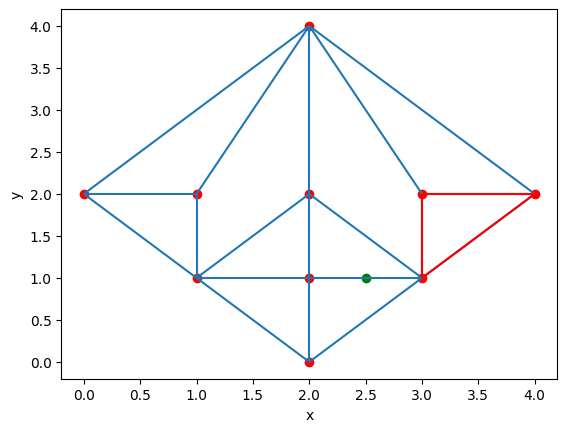

In [21]:
point2=(2.5,1)
vis2,edges=separators_method_point_location_algorithm_visualiser(raw.test2_vertices, raw.test2_edges,point2)
vis2.show()

In [22]:
point3=(4,7)
vis3,e=separators_method_point_location_algorithm_visualiser(raw.vertices, raw.edges,point3)
vis3.show()

[((4, 1), (8, 3)), ((8, 3), (6, 4)), ((6, 4), (5, 7)), ((5, 7), (6, 10))]
None


ValueError: cannot reshape array of size 1 into shape (2,2)